# Recurrent Neural Networks

In this lab we will experiment with recurrent neural networks. We will build a text generation model that predicts a word given the previous words, and hence will allow us to generate a sentence. This can easily be extended to generating a sentence description for a given input image. RNNs are a useful type of model for predicting sequences or handling sequences of things as inputs. In this lab we will use again Pytorch's nn library.

We will also be using the COCO dataset which includes images + textual descriptions (captions) + other annotations. We can browse the dataset here: http://cocodataset.org/#home

First, let's import libraries and make sure we have everything properly installed.

In [84]:
import torch, json, string
import torch.nn as nn
import torch.autograd
from torch.autograd import Variable
import torch.utils.data as data
import numpy as np
from nltk.tokenize import word_tokenize
import torchvision.models as models
import matplotlib.pyplot as plt
import pickle
import torchvision.transforms as transforms
from PIL import Image
import torch.optim as optim
import numpy as np
from skimage.restoration import (denoise_wavelet, estimate_sigma)
%matplotlib inline

## 1. Loading and Preprocessing the Text
Pytorch comes with a Dataset class for the COCO dataset but I will write my own class here. This class does two important things: 1) Building a vocabulary with the most frequent words, 2) Building utilities to convert a sentence into a list of word ids, and back. We are not going to be using the images for the purposes of the lab but you will use them in the assignment questions.

In [110]:
from tqdm import tqdm_notebook as tqdm

class CocoCaptions(data.Dataset):
    # Load annotations in the initialization of the object.
    def __init__(self, captionsFile, vocabulary = None):
        self.data = json.load(open(captionsFile))
        self.imageIds = self.data['images']
        self.annotations = self.data['annotations']
        
        # Build a vocabulary if not provided.
        if not vocabulary:
            self.build_vocabulary()
        else:
            self.vocabulary = vocabulary
        
    # Build a vocabulary using the top 5000 words.
    def build_vocabulary(self, vocabularySize = 5000):
        # Count words, this will take a while.
        word_counter = dict()
        for annotation in tqdm(self.annotations, desc = 'Building vocabulary'):
            words = word_tokenize(annotation['caption'].lower())
            for word in words:
                word_counter[word] = word_counter.get(word, 0) + 1
                
        # Sort the words and find keep only the most frequent words.
        sorted_words = sorted(list(word_counter.items()), 
                              key = lambda x: -x[1])
        most_frequent_words = [w for (w, c) in sorted_words[:vocabularySize]]
        word2id = {w: (index + 1) for (index, w) in enumerate(most_frequent_words)}
        
        # Add a special characters for START, END sentence, and UNKnown words.
        word2id['[END]'] = 0
        word2id['[START]'] = len(word2id)
        word2id['UNK'] = len(word2id)
        id2word = {index: w for (w, index) in word2id.items()}
        self.vocabulary = {'word2id': word2id, 'id2word': id2word}
    
    # Transform a caption into a list of word ids.
    def caption2ids(self, caption):
        word2id = self.vocabulary['word2id']
        caption_ids = [word2id.get(w, word2id['UNK']) for w in word_tokenize(caption.lower())]
        caption_ids.insert(0, word2id['[START]'])
        caption_ids.append(word2id['[END]'])
        return torch.LongTensor(caption_ids)
    
    # Transform a list of word ids into a caption.
    def ids2caption(self, caption_ids):
        id2word = self.vocabulary['id2word']
        return string.join([id2word[w] for w in caption_ids], " ")
    
    # Return imgId, and a random caption for that image.
    def __getitem__(self, index):
        annotation = self.annotations[index]
        return annotation['image_id'], self.caption2ids(annotation['caption'])
    
    # Return the number of elements of the dataset.
    def __len__(self):
        return len(self.annotations)
    
# Let's test the data class.
trainData = CocoCaptions('annotations/captions_train2014.json')
print('Number of training examples: ', len(trainData))

# It would be a mistake to build a vocabulary using the validation set so we reuse.
valData = CocoCaptions('annotations/captions_val2014.json', vocabulary = trainData.vocabulary)
print('Number of validation examples: ', len(valData))

# Print a sample from the training data.
imgId, caption = trainData[0]
print('imgId', imgId)
print('caption', caption.tolist())
print('captionString', trainData.ids2caption(caption))

HBox(children=(IntProgress(value=0, description=u'Building vocabulary', max=414113), HTML(value=u'')))


('Number of training examples: ', 414113)
('Number of validation examples: ', 202654)
('imgId', 318556)
('caption', [5001, 1, 141, 512, 8, 668, 415, 277, 57, 0])
('captionString', u'[START] a very clean and well decorated empty bathroom [END]')


## 2. Making a Data Loader that can Handle Sequences.

Handling sequences is special when processing batches of inputs because each sequence can have a different length. This makes batching complicated, and different libraries have different ways of handling this which might be easier or harder to deal with. Here we are padding the sequences to the maximum sequence length in a given batch. Additionally pytorch has nice utility functions that require sorting the sequences in a batch from longest to shortest.

In [111]:
# The batch builder will pack all sequences of different length into a single tensor by 
# padding shorter sequences with a padding token.
def customBatchBuilder(samples):
    imgIds, captionSeqs = zip(*samples)
    
    # Sort sequences based on length.
    seqLengths = [len(seq) for seq in captionSeqs]
    maxSeqLength = max(seqLengths)
    sorted_list = sorted(zip(list(imgIds), captionSeqs, seqLengths), key = lambda x: -x[2])
    imgIds, captionSeqs, seqLengths = zip(*sorted_list)
    
    # Create tensor with padded sequences.
    paddedSeqs = torch.LongTensor(len(imgIds), maxSeqLength)
    paddedSeqs.fill_(0)
    for (i, seq) in enumerate(captionSeqs):
        paddedSeqs[i, :len(seq)] = seq
    return imgIds, paddedSeqs.t(), seqLengths

# Data loaders in pytorch can use a custom batch builder, which we are using here.
trainLoader = data.DataLoader(trainData, batch_size = 128, 
                              shuffle = True, num_workers = 0,
                              collate_fn = customBatchBuilder)
valLoader = data.DataLoader(valData, batch_size = 128, 
                            shuffle = False, num_workers = 0,
                            collate_fn = customBatchBuilder)

# Now let's try using the data loader.
index, (imgIds, paddedSeqs, seqLengths) = next(enumerate(trainLoader))
print('imgIds', len(imgIds), imgIds)
print('paddedSequences', paddedSeqs.size())
print('seqLengths', len(seqLengths), seqLengths)

('imgIds', 128, (64350, 510209, 551481, 415008, 418155, 529629, 334158, 162250, 527666, 369529, 15374, 81743, 32339, 433805, 85625, 236840, 397161, 548822, 504191, 576218, 510549, 327895, 188723, 170780, 321344, 323661, 555857, 575325, 217201, 466294, 401400, 164043, 207083, 143594, 282949, 507166, 22658, 223154, 493959, 342998, 483766, 245209, 342718, 249856, 155376, 580629, 115967, 443545, 236759, 157188, 290720, 124190, 43809, 427308, 527243, 368490, 5256, 365879, 560571, 55184, 577362, 272510, 233588, 310206, 526877, 270154, 512503, 546515, 419609, 184416, 49974, 436161, 160159, 196002, 153572, 104846, 387176, 369838, 203429, 400625, 12183, 35358, 95061, 495182, 57849, 352288, 552463, 393169, 75614, 569592, 271505, 508669, 13292, 219225, 140729, 269079, 203710, 198057, 318955, 164572, 151353, 170785, 1622, 454502, 245654, 384755, 426146, 163598, 131044, 499801, 331105, 421804, 330878, 479880, 560655, 165376, 421557, 292999, 416697, 535318, 22882, 202115, 219946, 359805, 82898, 5729



## 3. Building our model using a Recurrent Neural Network.
We will build a model that predicts the next word based on the previous word using a recurrent neural network. Additionally we will be using an Embedding layer which will assign a unique vector to each word. The network will be trained with a softmax + negative log likelihood loss. Similar to classification we will be trying to optimize for the correct word at each time-step.

In [112]:
# By now, we should know that pytorch has a functional implementation (as opposed to class version)
# of many common layers, which is especially useful for layers that do not have any parameters.
# e.g. relu, sigmoid, softmax, etc.
import torch.nn.functional as F

class TextGeneratorModel(nn.Module):
    # The model has three layers: 
    #    1. An Embedding layer that turns a sequence of word ids into 
    #       a sequence of vectors of fixed size: embeddingSize.
    #    2. An RNN layer that turns the sequence of embedding vectors into 
    #       a sequence of hiddenStates.
    #    3. A classification layer that turns a sequence of hidden states into a 
    #       sequence of softmax outputs.
    def __init__(self, vocabularySize, rnn_cell_type=''):
        super(TextGeneratorModel, self).__init__()
        # See documentation for nn.Embedding here:
        # http://pytorch.org/docs/master/nn.html#torch.nn.Embedding
        self.embedder = nn.Embedding(vocabularySize, 300)
        if rnn_cell_type == 'LSTM':
            self.rnn = nn.LSTM(300, 512, batch_first = False)
        else:
            self.rnn = nn.RNN(300, 512, batch_first = False)
        self.classifier = nn.Linear(512, vocabularySize)
        self.vocabularySize = vocabularySize

    # The forward pass makes the sequences go through the three layers defined above.
    def forward(self, paddedSeqs, initialHiddenState):
        batchSequenceLength = paddedSeqs.size(0)  # 0-dim is sequence-length-dim.
        batchSize = paddedSeqs.size(1)  # 1-dim is batch dimension.
        
        # Transform word ids into an embedding vector.
        embeddingVectors = self.embedder(paddedSeqs)
        
        # Pass the sequence of word embeddings to the RNN.
        rnnOutput, finalHiddenState = self.rnn(embeddingVectors, initialHiddenState)
        
        # Collapse the batch and sequence-length dimensions in order to use nn.Linear.
        flatSeqOutput = rnnOutput.view(-1, 512)
        predictions = self.classifier(flatSeqOutput)
        
        # Expand back the batch and sequence-length dimensions and return. 
        return predictions.view(batchSequenceLength, batchSize, self.vocabularySize), \
               finalHiddenState

# Let's test the model on some input batch.
vocabularySize = len(trainData.vocabulary['word2id'])
model = TextGeneratorModel(vocabularySize)

# Create the initial hidden state for the RNN.
index, (imgIds, paddedSeqs, seqLengths) = next(enumerate(trainLoader))
initialHiddenState = Variable(torch.Tensor(1, paddedSeqs.size(1), 512).zero_())
predictions, _ = model(torch.autograd.Variable(paddedSeqs), initialHiddenState)

print('Here are input and output size tensor sizes:')
# Inputs are seqLength x batchSize x 1 
print('inputs', paddedSeqs.size()) # 10 input sequences.
# Outputs are seqLength x batchSize x vocabularySize
print('outputs', predictions.size()) # 10 output softmax predictions over our vocabularySize outputs.

Here are input and output size tensor sizes:
('inputs', torch.Size([23, 128]))
('outputs', torch.Size([23, 128, 5003]))


## 3. Sampling a New Sentence from the Model.

The code below uses the RNN network as an RNN cell where we only pass one single input word, and a hidden state vector. Then we keep passing the previously predicted word, and previously predicted hidden state to predict the next word. Since the given model is not trained, it will just output a random sequence of words for now. Ideally, the trained model should also learn when to [END] a sentence.

In [113]:
def sample_sentence(model, use_cuda = False, use_LSTM = False):
    counter = 0
    limit = 200
    words = list()

    # Setup initial input state, and input word (we use "the").
    previousWord = torch.LongTensor(1, 1).fill_(trainData.vocabulary['word2id']['the'])
    previousHiddenState = torch.autograd.Variable(torch.Tensor(1, 1, 512).zero_())
    if use_LSTM: 
        cellState = torch.autograd.Variable(torch.Tensor(1, 1, 512).zero_())
    if use_cuda: 
        previousHiddenState = previousHiddenState.cuda()
        if use_LSTM:
            cellState = cellState.cuda()

    while True:
        # Predict the next word based on the previous hidden state and previous word.
        inputWord = torch.autograd.Variable(previousWord)
        if use_cuda: inputWord = inputWord.cuda()
        if use_LSTM:  
            predictions, hiddenState = model(inputWord, (previousHiddenState, cellState))
        else:
            predictions, hiddenState = model(inputWord, previousHiddenState)
        nextWordId = np.random.multinomial(1, F.softmax(predictions.squeeze()).data.cpu().numpy(), 1).argmax()
        words.append(trainData.vocabulary['id2word'][nextWordId])
        # Setup the inputs for the next round.
        previousWord.fill_(nextWordId)
        if use_LSTM: 
            previousHiddenState, cellState = hiddenState
        else:
            previousHiddenState = hiddenState

        # Keep adding words until the [END] token is generated.
        if nextWordId == trainData.vocabulary['word2id']['[END]'] or counter > limit:
            break
        counter += 1
    
    words.insert(0, 'the')
    words.insert(0, '[START]')
    return string.join(words, " ")

print(sample_sentence(model, use_cuda = False))

[START] the ( dryer jumps symbols neon transported guests straight portable product panting bulldog launching mitts doors cargo propellers burning shoot smiley be german family monitors businessmen magnets now remodeled shut date bark across claim glass boys perfect wireless placing rushing shrubs exposed blocks greenery shaggy patterned caption stormy salad sanctuary jars found hilly bidet cycles flooring chopsticks chases fresh goods spectators chairs birds cans sons passengers seed plant log tries lift rolling sexy turkey automatic rd tusked video presenting sniffing dog fencing olive hawaiian rugby else tracks instructions suitcase games dance plantains comb focus special forehand competing leather e claw half unable camera needed lets bringing coat meatball descending idly fell factory trays s ships knee indicate bushy paris littered label household peer theatre soldier catches barbecue movie basement balances falling speaking pockets markings houses cab boats pours shopping bread

## 3. Training the Model

Now that data is pre-processed, we can try training the model. An important part is to define our target labels or ground-truth labels. In this text generation model, we want to predict the next word based on the previous word. So we need to provide as the target a shifted version of the input sequence. The code below looks a lot like the code used for training previous models with only small modifications.

In [134]:
import tqdm as tqdmx
from tqdm import tqdm_notebook as tqdm
tqdmx.tqdm.get_lock().locks = []

def train_rnn_model(network, criterion, optimizer, trainLoader, valLoader, n_epochs = 10, use_gpu = False, use_LSTM = False):
    if use_gpu:
        network = network.cuda()
        criterion = criterion.cuda()
        
    train_loss_arr = [None]*n_epochs
    train_accuracy_arr = [None]*n_epochs
    valid_loss_arr = [None]*n_epochs
    valid_accuracy_arr = [None]*n_epochs
        
    # Training loop.
    for epoch in range(0, n_epochs):
        cum_loss = 0.0
        correct = 0.0
        counter = 0

        # Make a pass over the training data.
        t = tqdm(trainLoader, desc = 'Training epoch %d' % epoch)
        network.train()  # This is important to call before training!
        
        for (i, (imgIds, paddedSeqs, seqLengths)) in enumerate(t):

            # Wrap inputs, and targets into torch.autograd.Variable types.
            inputs = Variable(paddedSeqs[:len(paddedSeqs)-1])
            labels = Variable(paddedSeqs[1:])
            hiddenState = torch.Tensor(1, paddedSeqs.size(1), 512).zero_()
            
            if use_gpu:
                inputs = inputs.cuda()
                labels = labels.cuda()
                hiddenState = hiddenState.cuda()

            # Forward pass:
            if use_LSTM:
                hiddenState = (Variable(hiddenState), Variable(hiddenState))
            else:
                hiddenState = Variable(hiddenState)
            outputs, _ = network(inputs, hiddenState)
            outputs = outputs.view(-1, outputs.size(2))
            labels = labels.view(-1)
            loss = criterion(outputs, labels)

            # Backward pass:
            optimizer.zero_grad()
            # Loss is a variable, and calling backward on a Variable will
            # compute all the gradients that lead to that Variable taking on its
            # current value.
            loss.backward() 

            # Weight and bias updates.
            optimizer.step()

            # logging information.
            cum_loss += loss.data[0]
            max_scores, max_labels = outputs.data.max(1)
            correct += (max_labels == labels.data).sum()
            counter += labels.size(0)
            t.set_postfix(loss = cum_loss / (1 + i), accuracy = 100 * correct / counter)
        
            train_loss_arr[epoch] = cum_loss / (1 + i)
            train_accuracy_arr[epoch] = 100*correct / counter
        
        # Make a pass over the validation data.
        correct = 0.0
        cum_loss = 0.0
        counter = 0
        t = tqdm(valLoader, desc = 'Validation epoch %d' % epoch)
        network.eval()  # This is important to call before evaluating!
        for (i, (imgIds, paddedSeqs, seqLengths)) in enumerate(t):

            # Wrap inputs, and targets into torch.autograd.Variable types.
            inputs = Variable(paddedSeqs[:len(paddedSeqs)-1])
            labels = Variable(paddedSeqs[1:])
            hiddenState = torch.Tensor(1, paddedSeqs.size(1), 512).zero_()
            
            if use_gpu:
                inputs = inputs.cuda()
                labels = labels.cuda()
                hiddenState = hiddenState.cuda()

            # Forward pass:
            if use_LSTM:
                hiddenState = (Variable(hiddenState), Variable(hiddenState))
            else:
                hiddenState = Variable(hiddenState)
            outputs, _ = network(inputs, hiddenState)
            outputs = outputs.view(-1, outputs.size(2))
            labels = labels.view(-1)
            loss = criterion(outputs, labels)

            # logging information.
            cum_loss += loss.data[0]
            max_scores, max_labels = outputs.data.max(1)
            correct += (max_labels == labels.data).sum()
            counter += labels.size(0)
            t.set_postfix(loss = cum_loss / (1 + i), accuracy = 100 * correct / counter)
        
            valid_loss_arr[epoch] = cum_loss / (1 + i)
            valid_accuracy_arr[epoch] = 100*correct / counter
        
    plt.subplot(211)
    plt.xlabel('epoch')
    plt.ylabel('loss scores')
    axes = plt.gca()
    axes.set_ylim([0,2.0])
    plt.plot(xrange(n_epochs),train_loss_arr)
    plt.plot(xrange(n_epochs),valid_loss_arr)

    plt.subplot(212) 
    plt.xlabel('epoch')
    plt.ylabel('accuracy scores')
    axes = plt.gca()
    axes.set_ylim([0,100])
    plt.plot(xrange(n_epochs),train_accuracy_arr)
    plt.plot(xrange(n_epochs),valid_accuracy_arr)

Now to the actual training call, notice how unlike previous experiments we are using here RMSprop which is a different type of optimizer that is often preferred for recurrent neural networks, although others such as SGD, and ADAM will also work. Additionally we are using nn.NLLLoss for the loss function, which is equivalent to the nn.CrossEntropyLoss function used before. The only difference is that nn.CrossEntropyLoss does the log_softmax operation for us, however in our implementation, we already applied log_softmax to the outputs of the model.

HBox(children=(IntProgress(value=0, description=u'Training epoch 0', max=3236), HTML(value=u'')))

Exception in thread Thread-8:
Traceback (most recent call last):
  File "/root/miniconda2/envs/torch_linux/lib/python2.7/threading.py", line 801, in __bootstrap_inner
    self.run()
  File "/root/miniconda2/envs/torch_linux/lib/python2.7/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/root/miniconda2/envs/torch_linux/lib/python2.7/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



HBox(children=(IntProgress(value=0, description=u'Validation epoch 0', max=1584), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'Training epoch 1', max=3236), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'Validation epoch 1', max=1584), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'Training epoch 2', max=3236), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'Validation epoch 2', max=1584), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'Training epoch 3', max=3236), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'Validation epoch 3', max=1584), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'Training epoch 4', max=3236), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'Validation epoch 4', max=1584), HTML(value=u'')))

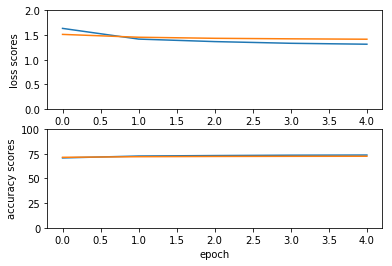

In [135]:
vocabularySize = len(trainData.vocabulary['word2id'])
model = TextGeneratorModel(vocabularySize)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0005)

# Train the previously defined model.
train_rnn_model(model, criterion, optimizer, trainLoader, valLoader, n_epochs = 5, use_gpu = True)

## Lab Questions (10pts)
<span><b>1.</b></span> (2pts) What is the number of parameters of the TextGeneratorModel? 

In [145]:
# Show how did you come up with that number here.
numParameters = 0
for name, parameter in model.named_parameters():
    numParameter = reduce(lambda x, y: x * y, parameter.data.size(), 1)
    print name, parameter.data.size(), numParameter
    numParameters += numParameter
print 'The number of parameters of the TextGeneratorModel is: ', numParameters

embedder.weight torch.Size([5003, 300]) 1500900
rnn.weight_ih_l0 torch.Size([512, 300]) 153600
rnn.weight_hh_l0 torch.Size([512, 512]) 262144
rnn.bias_ih_l0 torch.Size([512]) 512
rnn.bias_hh_l0 torch.Size([512]) 512
classifier.weight torch.Size([5003, 512]) 2561536
classifier.bias torch.Size([5003]) 5003
The number of parameters of the TextGeneratorModel is:  4484207


<span><b>2.</b></span> (4pts) Provide an implementation for the function train_rnn_model from section 3, this will be similar to the train_model function used in the previous lab. Then train the model and report a few sentences generated by your model. Use the following figure as reference to make sure you are using the right inputs and targets to train the model. The loss function between predictions and targets should be nn.CrossEntropyLoss(), so you might need to collapse the batch and sequence-length dimensions before passing them to the loss function.

<img src="rnn.png" width="80%"> 

In [137]:
# implement train_rnn_model and then train the model using this function. 
# Show here a couple of sentences sampled from your model.
print(sample_sentence(model, use_cuda = True))
print(sample_sentence(model, use_cuda = True))
print(sample_sentence(model, use_cuda = True))
print(sample_sentence(model, use_cuda = True))
print(sample_sentence(model, use_cuda = True))

[START] the calculator in the kitchen and a fridge . [END]
[START] the other players looking in the direction . [END]
[START] the reflection of a vintage car on the street . [END]
[START] the stream of the river is quiet during a UNK man . [END]
[START] the corner edge of a street with the red panel is in front of a building . [END]


<span><b>3. </b></span> (4pts) Create an ImageCaptioningModel class here that predicts a sentence given an input image. This should be an implementation of the model in this paper https://arxiv.org/pdf/1411.4555.pdf (See figure 3 in the paper). This model is very similar to the one implemented in this lab except that the first RNN cell gets the output of a CNN as its input. I'm also illustrating it below using a figure similar to the one in the previous question. For the CNN use Resnet-18. Note: You do not need to train this model, only define it. Feel free to start from the code for the TextGeneratorModel. <img src="im2text.png" width="80%">

In [138]:
class ImageCaptioningModel(nn.Module):
    # The model has three layers: 
    #    1. An Embedding layer that turns a sequence of word ids into 
    #       a sequence of vectors of fixed size: embeddingSize.
    #    2. An RNN layer that turns the sequence of embedding vectors into 
    #       a sequence of hiddenStates.
    #    3. A classification layer that turns a sequence of hidden states into a 
    #       sequence of softmax outputs.
    def __init__(self, vocabularySize):
        super(ImageCaptioningModel, self).__init__()
        # See documentation for nn.Embedding here:
        # http://pytorch.org/docs/master/nn.html#torch.nn.Embedding
        self.embedder = nn.Embedding(vocabularySize, 300)
        self.rnn = nn.RNN(300, 512, batch_first = False)
        self.classifier = nn.Linear(512, vocabularySize)
        self.vocabularySize = vocabularySize
        self.cnn = models.resnet18(pretrained = True)
        self.linear = nn.Linear(1000, 300)


    # The forward pass makes the sequences go through the three layers defined above.
    def forward(self, image, paddedSeqs, initialHiddenState):
        img_cnn = self.cnn(image)
        print img_cnn.size()
        start_seq = self.linear(img_cnn)
        print start_seq.size()
        batchSequenceLength = paddedSeqs.size(0)  # 0-dim is sequence-length-dim.
        batchSize = paddedSeqs.size(1)  # 1-dim is batch dimension.
        
        # Transform word ids into an embedding vector.
        embeddingVectors = self.embedder(paddedSeqs)
        embeddingVectors[0] = start_seq
        # Pass the sequence of word embeddings to the RNN.
        rnnOutput, finalHiddenState = self.rnn(embeddingVectors, initialHiddenState)
        
        # Collapse the batch and sequence-length dimensions in order to use nn.Linear.
        flatSeqOutput = rnnOutput.view(-1, 512)
        predictions = self.classifier(flatSeqOutput)
        
        # Expand back the batch and sequence-length dimensions and return. 
        return predictions.view(batchSequenceLength, batchSize, self.vocabularySize), \
               finalHiddenState

preprocessFn = transforms.Compose([transforms.Scale(256), 
                                   transforms.CenterCrop(224), 
                                   transforms.ToTensor(), 
                                   transforms.Normalize(mean = [0.485, 0.456, 0.406], 
                                                        std=[0.229, 0.224, 0.225])])
# unsqueeze(0) adds a dummy batch dimension which is required for all models in pytorch.
image = Image.open('../deep_learning_lab_for_vision/test_image.jpg').convert('RGB')
# Try your own image here. This is a picture of my toaster at home.
image_preprocessed = preprocessFn(image)
image_var = Variable(torch.stack( [image_preprocessed]*trainLoader.batch_size ))
ImageCaptioning_model = ImageCaptioningModel(vocabularySize).cuda()

index, (imgIds, paddedSeqs, seqLengths) = next(enumerate(trainLoader))
hiddenState = Variable(torch.Tensor(1, paddedSeqs.size(1), 512).zero_())
print image_var.size()
ImageCaptioning_model(image_var.cuda(), Variable(paddedSeqs).cuda(), hiddenState.cuda())


torch.Size([128, 3, 224, 224])
torch.Size([128, 1000])
torch.Size([128, 300])


(Variable containing:
 ( 0  ,.,.) = 
  -2.0559e-01 -1.3285e-02  7.4265e-02  ...   2.1870e-01  1.3276e-01  3.8419e-02
  -2.0559e-01 -1.3285e-02  7.4264e-02  ...   2.1870e-01  1.3276e-01  3.8418e-02
  -2.0559e-01 -1.3285e-02  7.4265e-02  ...   2.1870e-01  1.3276e-01  3.8419e-02
                  ...                   ⋱                   ...                
  -2.0559e-01 -1.3285e-02  7.4264e-02  ...   2.1870e-01  1.3276e-01  3.8418e-02
  -2.0559e-01 -1.3285e-02  7.4265e-02  ...   2.1870e-01  1.3276e-01  3.8419e-02
  -2.0559e-01 -1.3285e-02  7.4264e-02  ...   2.1870e-01  1.3276e-01  3.8418e-02
 
 ( 1  ,.,.) = 
   3.2963e-02  1.3786e-01 -8.2690e-02  ...  -2.0902e-01  1.8599e-01 -2.0863e-01
   3.2963e-02  1.3786e-01 -8.2691e-02  ...  -2.0902e-01  1.8599e-01 -2.0863e-01
  -4.1260e-01  1.0089e-01  3.0453e-01  ...  -5.9490e-03  8.9353e-02  4.9174e-02
                  ...                   ⋱                   ...                
  -3.1460e-01  1.5596e-01  5.7831e-02  ...  -3.3544e-01 -1.6589e-0

### Optional Questions (8pts)

<span><b>1. </b></span> (1pts) What is the number of parameters of the ImageCaptioningModel from Q3?

In [146]:
ImageCaptioning_model = ImageCaptioningModel(vocabularySize)

# Show how did you come up with that number here.
numParameters = 0
for name, parameter in ImageCaptioning_model.named_parameters():
    numParameter = reduce(lambda x, y: x * y, parameter.data.size(), 1)
    print name, parameter.data.size(), numParameter
    numParameters += numParameter
print 'The number of parameters of the ImageCaptioningModel is: ', numParameters

embedder.weight torch.Size([5003, 300]) 1500900
rnn.weight_ih_l0 torch.Size([512, 300]) 153600
rnn.weight_hh_l0 torch.Size([512, 512]) 262144
rnn.bias_ih_l0 torch.Size([512]) 512
rnn.bias_hh_l0 torch.Size([512]) 512
classifier.weight torch.Size([5003, 512]) 2561536
classifier.bias torch.Size([5003]) 5003
cnn.conv1.weight torch.Size([64, 3, 7, 7]) 9408
cnn.bn1.weight torch.Size([64]) 64
cnn.bn1.bias torch.Size([64]) 64
cnn.layer1.0.conv1.weight torch.Size([64, 64, 3, 3]) 36864
cnn.layer1.0.bn1.weight torch.Size([64]) 64
cnn.layer1.0.bn1.bias torch.Size([64]) 64
cnn.layer1.0.conv2.weight torch.Size([64, 64, 3, 3]) 36864
cnn.layer1.0.bn2.weight torch.Size([64]) 64
cnn.layer1.0.bn2.bias torch.Size([64]) 64
cnn.layer1.1.conv1.weight torch.Size([64, 64, 3, 3]) 36864
cnn.layer1.1.bn1.weight torch.Size([64]) 64
cnn.layer1.1.bn1.bias torch.Size([64]) 64
cnn.layer1.1.conv2.weight torch.Size([64, 64, 3, 3]) 36864
cnn.layer1.1.bn2.weight torch.Size([64]) 64
cnn.layer1.1.bn2.bias torch.Size([64]) 6

<span><b>2. </b></span> (3pts) Modify the TextGeneratorModel to use an LSTM instead, and retrain the model. Report results using this model.

HBox(children=(IntProgress(value=0, description=u'Training epoch 0', max=3236), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'Validation epoch 0', max=1584), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'Training epoch 1', max=3236), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'Validation epoch 1', max=1584), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'Training epoch 2', max=3236), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'Validation epoch 2', max=1584), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'Training epoch 3', max=3236), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'Validation epoch 3', max=1584), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'Training epoch 4', max=3236), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'Validation epoch 4', max=1584), HTML(value=u'')))

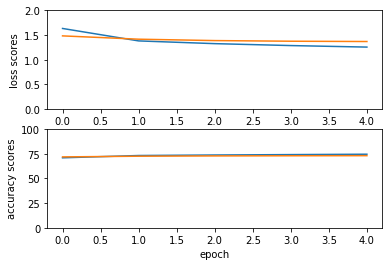

In [148]:
LSTM_model = TextGeneratorModel(vocabularySize, rnn_cell_type='LSTM')
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(LSTM_model.parameters(), lr = 0.0005)

# Train the previously defined model.
train_rnn_model(LSTM_model, criterion, optimizer, trainLoader, valLoader, n_epochs = 5, use_gpu = True, use_LSTM=True)

In [141]:
print(sample_sentence(LSTM_model, use_cuda = True, use_LSTM = True))
print(sample_sentence(LSTM_model, use_cuda = True, use_LSTM = True))
print(sample_sentence(LSTM_model, use_cuda = True, use_LSTM = True))
print(sample_sentence(LSTM_model, use_cuda = True, use_LSTM = True))
print(sample_sentence(LSTM_model, use_cuda = True, use_LSTM = True))

[START] the fence event overlooks of the beach [END]
[START] the ironing pushes soap barely be UNK . [END]
[START] the stylish carrying white cat sniffing the other UNK and brown teddy [END]
[START] the summer torn on bed . [END]
[START] the bathroom window shows the bulldog is shown in the mirror . [END]


<span><b>3. </b></span> (4pts) In this question, you will have to reconstruct an input image from its activations. I will not provide you with the image, only the activation values obtained for a certain layer. You will have access to the code that was used to compute these activations. You will have to use back-propagation to reconstruct the input image. Show the reconstructed input image and tell us who is in the picture. Note: Look at the content reconstruction from outputs performed in https://www.cv-foundation.org/openaccess/content_cvpr_2016/html/Gatys_Image_Style_Transfer_CVPR_2016_paper.html

In [142]:
vggmodel = models.vgg16(pretrained = True).cuda()

In [143]:
preprocessFn = transforms.Compose([transforms.Scale(256), 
                                   transforms.CenterCrop(224), 
                                   transforms.ToTensor(), 
                                   transforms.Normalize(mean = [0.485, 0.456, 0.406], 
                                                        std=[0.229, 0.224, 0.225])])

def model_F(input, kOutput = 19):
    prev_input = input
    for layer_id in range(0, kOutput + 1):
        current_input = vggmodel.features[layer_id](prev_input)
        prev_input = current_input
    return current_input

# # Read the incognito image. (Obviously this is not provided in the Lab assignment.)
# image = preprocessFn(Image.open('incognito.jpg').convert('RGB'))
# image = Variable(image.unsqueeze(0))

# # Obtain the output of the VGG layer 19.
# model.eval()
# target = Variable(model_F(image).data) # Repack variable.

# print('image.size()', image.size())
# print('layer-19-output.size()', target.size())
# torch.save(target.data, open('layer-19-output.p', 'w'))

def imshow(img, show_greyscale=False, denoise=False):
    # convert torch tensor to PIL image and then show image inline.
    if denoise:
        rgb_image = np.moveaxis(img[0].numpy(), 0, -1)
        sigma_est = estimate_sigma(rgb_image, multichannel=True, average_sigmas=True)
        img = denoise_wavelet(rgb_image, multichannel=True, convert2ycbcr=True, mode='soft',
                                 sigma=sigma_est/4)
        plt.imshow(img, aspect = None)
    elif show_greyscale:
        rgb_image = img[0]
        r_image = rgb_image[0]
        g_image = rgb_image[1]
        b_image = rgb_image[2]

        grayscale_image = (r_image + g_image + b_image).div(3.0)
        plt.imshow(grayscale_image.numpy(), cmap=plt.get_cmap('gray'), aspect = None)
    else:
        img = transforms.ToPILImage()(img[0].cpu() * 0.5 + 0.5) # denormalize tensor before convert
        plt.imshow(img, aspect = None)

    plt.axis('off')
    plt.gcf().set_size_inches(4, 4)
    plt.show()

target = torch.load(open('layer-19-output.p'))
print(target.size())
# imshow(target)
# print(vggmodel)

torch.Size([1, 512, 28, 28])


In [133]:
# Your solution goes here. Show the reconstructed input and tell us who is depicted in the incognito.jpg image.
class ContentLoss(nn.Module):

    def __init__(self, target):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        self.target = target.detach() 
        self.criterion = nn.SmoothL1Loss()

    def forward(self, input):
        self.loss = self.criterion(input, self.target)
        self.output = input
        return self.output

    def backward(self, retain_graph=True):
        self.loss.backward(retain_graph=retain_graph)
        return self.loss


# test with white noise
input_img = Variable(torch.randn((1,3,224,224))).type(torch.cuda.FloatTensor)

# test with trump.jpg
# image = preprocessFn(Image.open('trump.jpg').convert('RGB')).cuda()
# input_img = Variable(image.unsqueeze(0))

# test with zeros
# input_img = Variable(torch.Tensor(1,3,224,224).zero_()).type(torch.cuda.FloatTensor)


target_cuda = Variable(target.cuda())
content_loss = ContentLoss(target_cuda)

model = nn.Sequential()
model.add_module('loss1', content_loss)
model = model.cuda()
# print(model)

input_param = nn.Parameter(input_img.data)

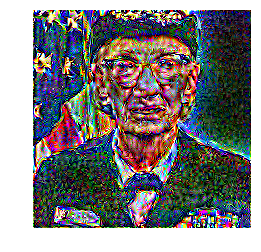

0.631678104401
0.629598975182
0.627055048943
0.625201106071
0.623887121677
0.622522175312
0.621871232986
0.62069606781
0.620366454124
0.619845926762


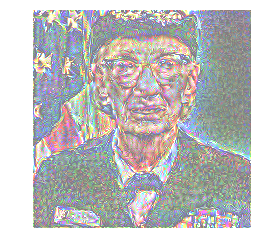

In [128]:
imshow(input_img.data.cpu(), denoise=True)

optimizer = optim.Adam([input_param], lr=9e-3, weight_decay=1e-5)

i = 0
while i < 10000:
    i+=1

    def closure():
        # correct the values of updated input image
        input_param.data.clamp_(0, 1)

        optimizer.zero_grad()
        model.forward(model_F(input_param))
        content_score = 0

        content_score += content_loss.backward()
        if i % 1000 == 0: print(content_score.data[0])
        return content_score

    optimizer.step(closure)

input_param.data.clamp_(0, 1)
output = input_param.data.cpu()

imshow(output, denoise=False)

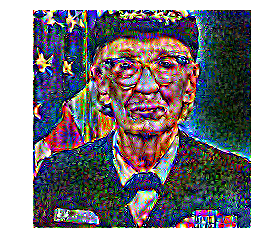

1.23626732826
1.23467433453
1.23232710361
1.23070776463
1.23127269745
1.22853434086
1.22978830338
1.23208105564
1.22688210011
1.22654986382


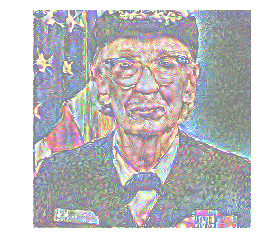

In [109]:
imshow(input_img.data.cpu(), denoise=True)

optimizer = optim.Adam([input_param], lr=9e-3, weight_decay=1e-5)
criterion = nn.SmoothL1Loss()

i = 0
while i < 10000:
    i+=1

    def closure():
        # correct the values of updated input image
        input_param.data.clamp_(0, 1)

        optimizer.zero_grad()
        model.forward(model_F(input_param))
        content_score = 0

        content_score += content_loss.backward()
        if i % 1000 == 0: print(content_score.data[0])
        return content_score

    optimizer.step(closure)

input_param.data.clamp_(0, 1)
output = input_param.data.cpu()

imshow(output, denoise=False)

I applied several optimizer and loss function to improve the image quality.
As a non-native person, I can only recognize US president Trump. So I have no idea who is this person from the picture above, a good guess should be some old US politician wearing glass, probably some four star general.

<div style="font-size:0.8em;color:#888;text-align:center;padding-top:20px;">If you find any errors or omissions in this material please contact me at vicente@virginia.edu</div>